# Recommender System for Moosic

The task:
Moosic is a little start-up that creates playlists curated by music experts and specialists in old and new trends. Users can subscribe to their website and listen to these playlists through their preferred Music App

Use Data Science to add a degree of automatisation to the creation of playlists. Build a first prototype model how to cluster songs for playlist with an inital set of 5000 songs.

Use KMeans to build the model.

Are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria? 

Is K-Means a good method to create playlists? Would you stick with this algorithm moving forward, or explore other methods to create playlists?


## Data preparation

In [347]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import pairwise_distances, silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.colors as mcolors
import math

In [348]:
pd.set_option("display.max_colwidth",100)
set_config(transform_output="pandas")

In [349]:
songs_df = pd.read_csv("../data/6.3.3_spotify_5000_songs.csv")

In [350]:
songs_df.head()

,Unnamed: 0,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
0,0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR1tcGFq7
1,1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwSJwTm5Zq
2,2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwnkn5PJYs
3,3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67WsAxryPFs
4,4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkIPPdp0eA


In [351]:
def cleaning_data(df_input):
    df_output = df_input.copy()
    # clean the columns from trailing spaces
    df_output = df_output.rename(columns=lambda x: x.strip())
    df_output = df_output.drop(columns=["Unnamed: 0"])
    
    #clean the songs and artists from trailing spaces

    songs_lst = df_output["name"].to_list()
    artists_lst = df_output["artist"].to_list()

    songs_clean = [song.strip() for song in songs_lst]
    artists_clean = [artist.strip() for artist in artists_lst]

    df_output["name"] = songs_clean
    df_output["artist"] = artists_clean
   
    # drop duplicates
    df_output =  df_output.loc[df_output.duplicated()==False,:]
    
    #separate the non numerical columns into a second dataframe
    songs_txt_features = df_output.loc[:,["name","artist","id","html"]]
    
    # drop the txt columns html and id from output
    df_output = df_output.drop(columns=["type","id","html", "duration_ms","time_signature"])
    
    return df_output, songs_txt_features

In [352]:
songs_cleaned = cleaning_data(songs_df)[0]
songs_txt_features = cleaning_data(songs_df)[1]

In [353]:
songs_cleaned = songs_cleaned.set_index(["name","artist"])

## Exploration of the dataset

In [355]:
songs_cleaned.shape

(5171, 11)

In [356]:
songs_cleaned.head()

,,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376
Saudade De Bahia,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039
"Canta Canta, Minha Gente",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698
Mulher Eu Sei,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802
Rosa Morena,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941


533 songs distinctively instrumental

In [358]:
songs_cleaned.loc[songs_cleaned.instrumentalness > 0.9,:].count()

danceability        536
energy              536
key                 536
loudness            536
mode                536
speechiness         536
acousticness        536
instrumentalness    536
liveness            536
valence             536
tempo               536
dtype: int64

In [359]:
# find correlations between single features
def correlation(songs_cleaned):
    columns_lst = songs_cleaned.columns.to_list()
    corr_dict = {column:[] for column in columns_lst}

    for key in corr_dict: 
        for column in columns_lst:
            corr_dict[key].append(songs_cleaned[key].corr(songs_cleaned[column]))
    corr_df = pd.DataFrame(corr_dict, 
                           index = corr_dict.keys()
                          )
    
    return corr_df

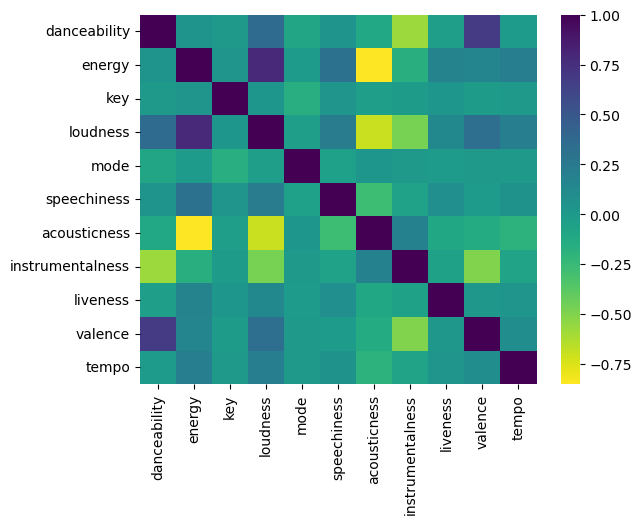

In [360]:
corr_df = correlation(songs_cleaned)

sns.heatmap(corr_df,
            cmap="viridis_r",
           );

## Scaling

we tested MinMax Scaling and Standard Scaler, but overall the robust scaler delivered better results to create distinctive clusters

In [363]:
# Use of a RobustSCaler and fit to dataset

robust = RobustScaler(with_centering=False, quantile_range=(10,90))
robust_fit = robust.fit_transform(songs_cleaned)

songs_scaled = pd.DataFrame(robust_fit,
                          index=songs_cleaned.index, 
                          columns=songs_cleaned.columns)

In [364]:
# Store the single features in a variable for easier plotting 
danceability = songs_scaled["danceability"]
energy = songs_scaled["energy"]
key = songs_scaled["key"]
loudness =  songs_scaled["loudness"]
tempo = songs_scaled["tempo"]
instrumentalness = songs_scaled["instrumentalness"]
speechiness = songs_scaled["speechiness"]
acousticness = songs_scaled["acousticness"]

Text(0.5, 1.0, 'acousticness')

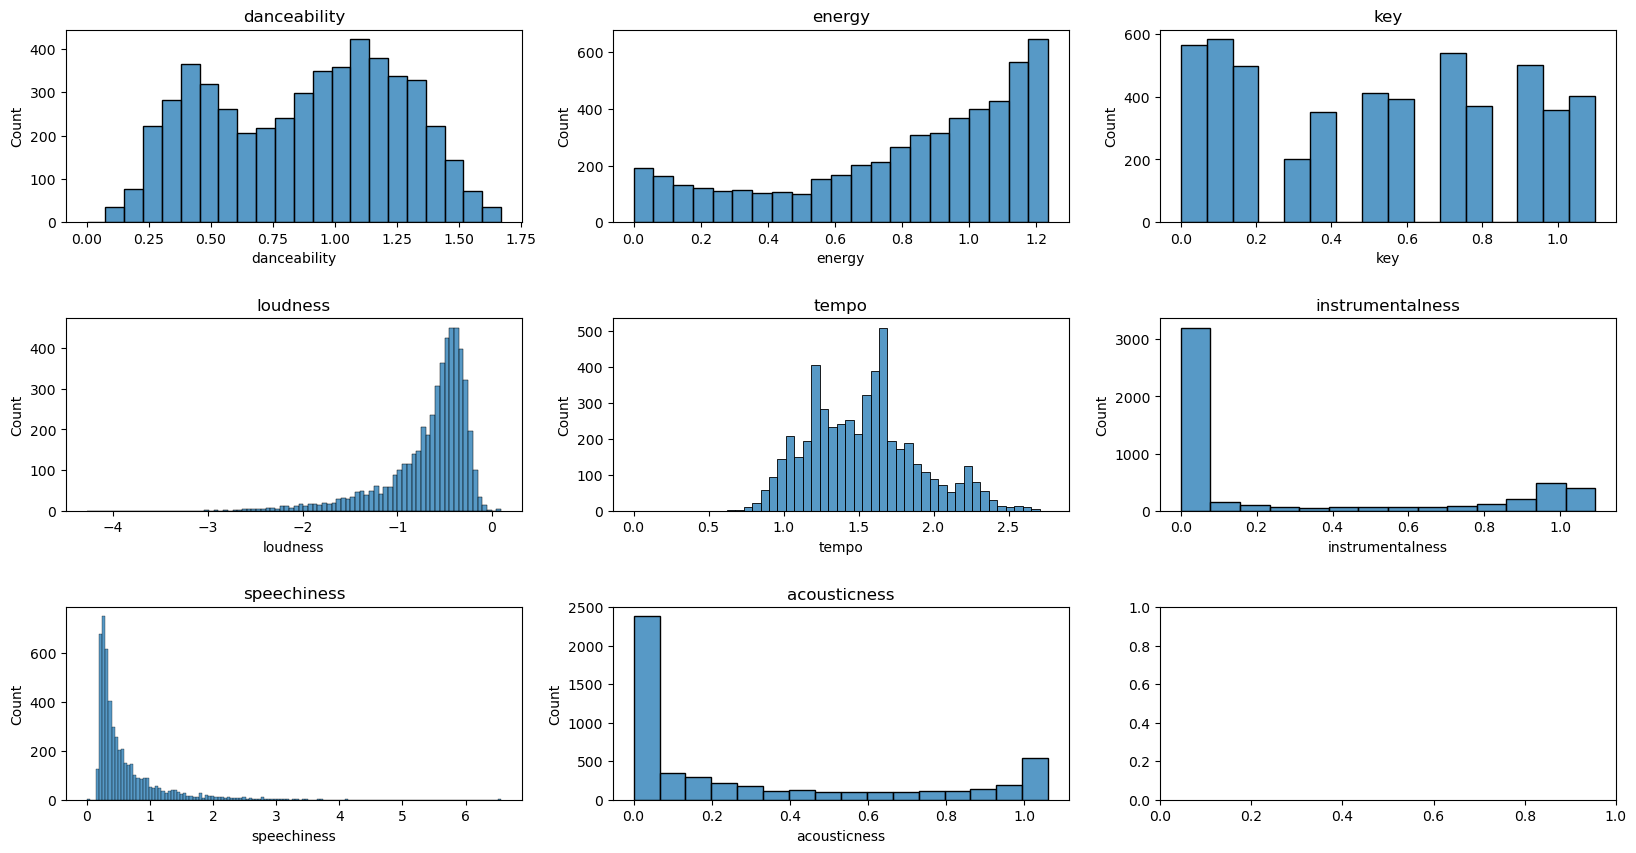

In [365]:
# Plot the distribution of each feature as histogram

# Subplots of with 3 rows and  3 columns 
fig,( (ax0, ax1, ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(nrows=3, ncols=3, sharex=False,
                                                            figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
sns.histplot(danceability, ax = ax0)
sns.histplot(energy, ax = ax1)
sns.histplot(key, ax = ax2)
sns.histplot(loudness, ax = ax3)
sns.histplot(tempo, ax = ax4)
sns.histplot(instrumentalness, ax = ax5)
sns.histplot(speechiness, ax = ax6)
sns.histplot(acousticness, ax = ax7)

ax0.set_title("danceability")
ax1.set_title("energy")
ax2.set_title("key")
ax3.set_title("loudness")
ax4.set_title("tempo")
ax5.set_title("instrumentalness")
ax6.set_title("speechiness")
ax7.set_title("acousticness")

##  PCA

Use of PCA to determine the most relevant combination of features

In [368]:
# Drop Key and Loudness, can be defined as irrelevant befrorehand
songs_scaled = songs_scaled.drop(columns =["liveness", "loudness"])
# define order of columns in  songs_scaled
songs_scaled = songs_scaled[["danceability","energy","speechiness","acousticness","instrumentalness","valence","tempo","key","mode"]]
# initialize PCA and Fit
pca = PCA()
pca.fit(songs_scaled)
pca_df = pca.transform(songs_scaled)

In [369]:
# explained variance ratio - in Dataframe 
expl_variance = pca.explained_variance_ratio_
pca_variance_df = pd.DataFrame(expl_variance, columns=["variances"])
pca_variance_df["pca_index_nr"] = range(len(expl_variance))

### Elbow method

visualization of PCA variances to get an idea of valid number with elbow method

''

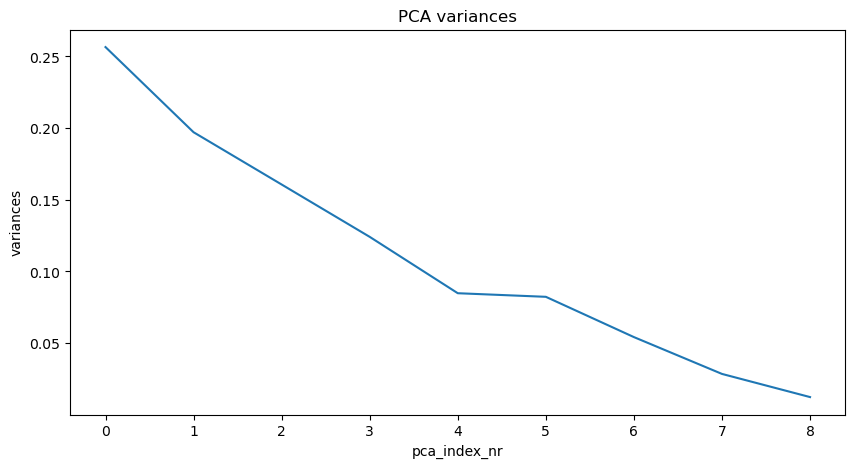

In [372]:
# lineplot of pca variance df
plt.subplots(figsize = (10,5))
(sns.lineplot( data = pca_variance_df,
             x = "pca_index_nr",
             y="variances",
            )
 .set(title ="PCA variances")
)
;


### Cumulative variances

to define the best pca number - use cumulative variance. 95% of variance should be explained

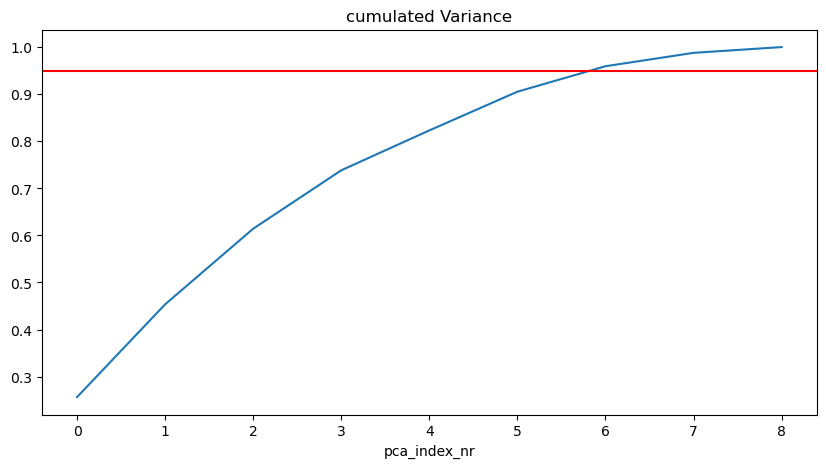

In [375]:
# plot with lineplot 
plt.subplots(figsize = (10,5))
( 
    sns.lineplot( data = pca_variance_df,
                 x = "pca_index_nr",
                 y = np.cumsum(expl_variance), # cumuluate the numbers of expl_variance
                )
    
    .set(title ="cumulated Variance")
)
plt.axhline(y=0.95, color="red") # Red line for 95% threshold

## Clustering

**finding the right number k clusters - visualization with inertia and silhouette scores via Elbow method**

In [378]:
#  Inertia and silhouette calculation
#maximum nr of clusters defined by number of songs per playlist --> should be greater than 50 

# Set the maximum number of clusters
max_clusters = 41

# Create empty lists to store the inertia and silhouette scores
inertia_lst = []
silhouette_lst = []

# Iterate over a range of values from 2 to max_clusters
for i in range(2, max_clusters):
    # Create a KMeans object with the specified number of clusters and fit
    my_kmeans = KMeans(n_clusters=i, random_state=19201)
    my_kmeans.fit(songs_scaled)
    # Get the labels assigned by the KMeans model
    label = my_kmeans.labels_
    # Calculate the silhouette score for the clustering
    sil_score = silhouette_score(songs_scaled, label)
    # Append the inertia and silhouette scores to their respective lists
    inertia_lst.append(my_kmeans.inertia_)
    silhouette_lst.append(sil_score)

# put into dataframe
scores_df = pd.DataFrame({"inertia":inertia_lst, "silhouette":silhouette_lst})
scores_df["k"] = range(2,max_clusters)



### Elbow Method

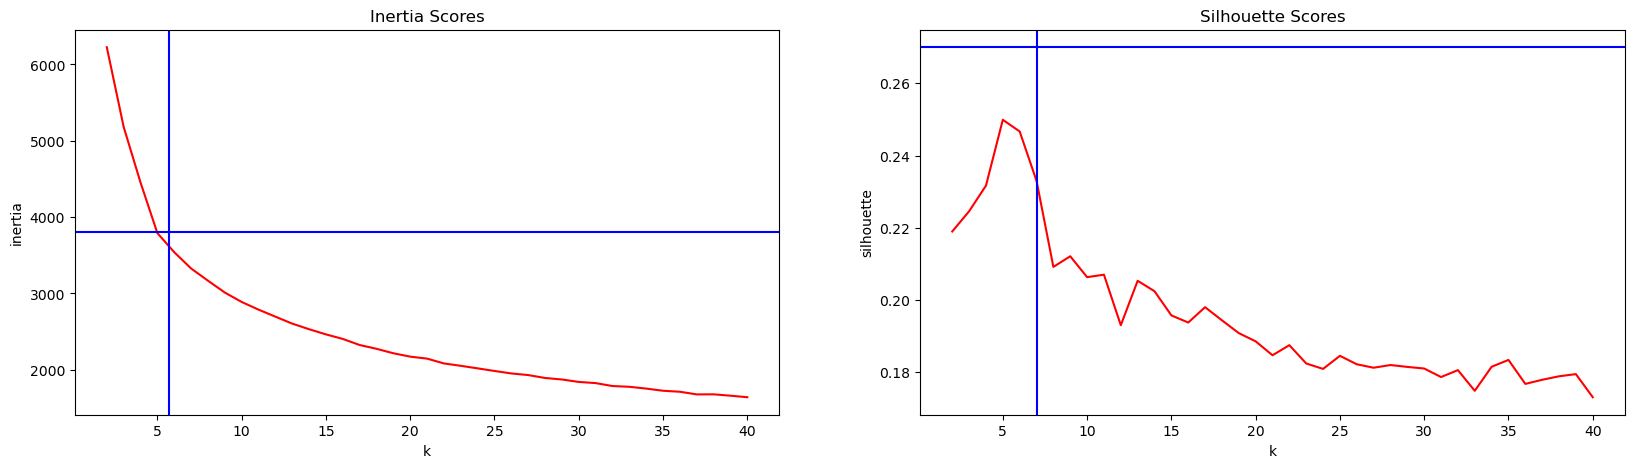

In [380]:
# plot in two columns silhouette and inertia as lineplot
fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(20,5))
sns.lineplot(data=scores_df,
               x = "k",
               y = "inertia",
               color = "red",
               ax = ax1
              )
sns.lineplot(data=scores_df,
               x = "k",
               y = "silhouette",
               color = "red",
               ax = ax2
              )

# Set titles of plots
ax1.set_title("Inertia Scores")
ax2.set_title("Silhouette Scores")
# create blue horizontal and vertical lines for better visibility
ax1.axhline(y=3800, color="blue")
ax1.axvline(x=5.7, color='blue')
ax2.axhline(y=0.27, color="blue")
ax2.axvline(x=7, color='blue')

plt.show()


In [381]:
# Fit KMenas with 6 clusters

my_kmeans = KMeans(n_clusters = 6, random_state = 19201)
my_kmeans.fit(songs_scaled)


KMeans(n_clusters=6, random_state=19201)

## Evaluating the clusters

**6 Clusters**

In [384]:
# create new dataframe with calculated distance to centre of cluster for each datapoint
labeled_df = (
  songs_scaled
  .assign(
     label=my_kmeans.labels_,  # Assign the labels from KMeans to a new column called 'label' 
     distance=[  # Create a list comprehension to calculate the distance for each data point
      my_kmeans.transform(songs_scaled.iloc[[i]]).iloc[0, my_kmeans.labels_[i]]
      for i in range(len(songs_scaled))
    ]
  )
  .sort_values(['distance'])  # Sort the DataFrame by the 'distance' column
)

In [385]:
# create dataframe Label_characteristics_df from labeld df to calculate mean and std for each cluster

label_characteristics_df = (
    songs_scaled
    .join(labeled_df.label)  #join between songs_scaled and labeled_df 
    .groupby('label') #groupy by cluster
    .agg(['mean','std']) #calculate mean and std
)

In [386]:
# calculate the cluster sizes 
cluster_sizes_df = (
  labeled_df['label'].value_counts().sort_index().rename('count').to_frame()
)
cluster_sizes_df

,count
label,
0,369
1,987
2,825
3,1764
4,421
5,805


In [387]:
# State the label for each arm of the chart
categories = [ tuple[0] for tuple in label_characteristics_df.columns if tuple[1] == 'mean' ]
categories.append(categories[0])
colormap = px.colors.qualitative.Plotly

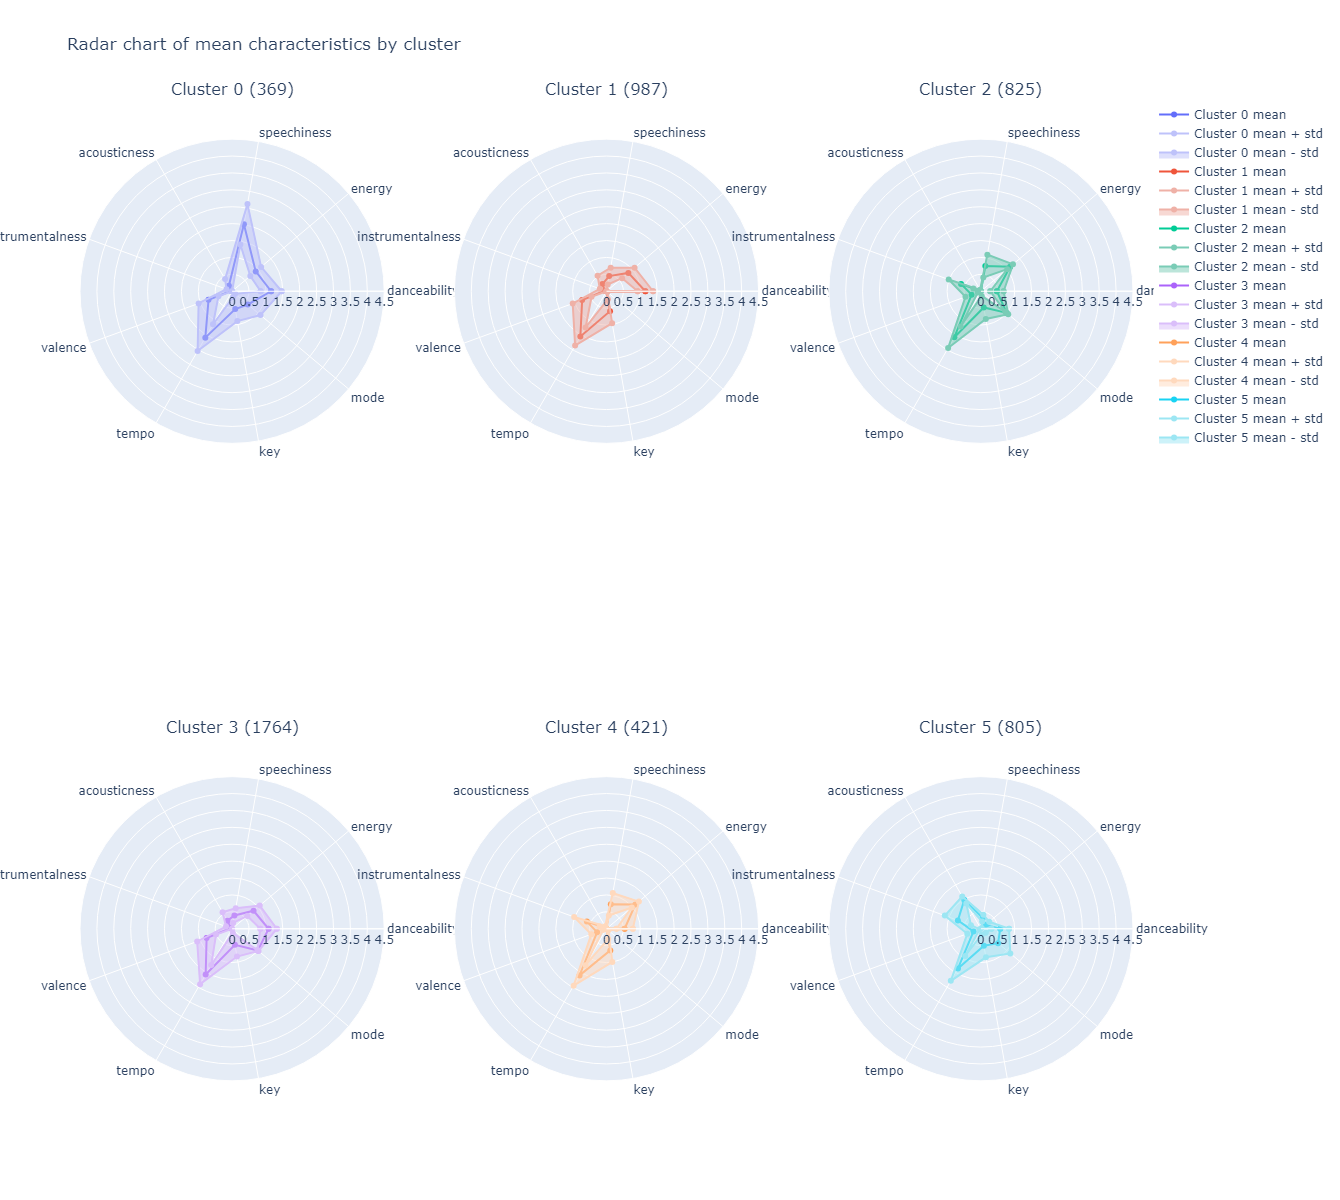

In [388]:
# Create an empty list to store the objects
trace_objects = []
k = 6

# Iterate over the unique cluster numbers and add an object for each cluster to the list
for label in np.arange(k):
    # Define colors for the cluster
    color = colormap[label % len(colormap)]
    light_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    light_color[1] *= 0.4
    light_color = mcolors.to_hex(mcolors.hsv_to_rgb(light_color))

    label_traces = []

    # Create a Scatterpolar object for the mean of each category
    label_means = go.Scatterpolar(
        r=[label_characteristics_df.loc[label, (category, 'mean')] for category in categories],
        theta=categories,
        line_color=color,
        name=f'Cluster {label} mean',
        subplot=f'polar{label+1}',
    )
    label_traces.append(label_means)

    # Create a Scatterpolar object for the mean plus/minus standard deviation of each category
    for plus_minus in [+1, -1]:
        label_mean_plus_std = go.Scatterpolar(
            r=[
                max(0, label_characteristics_df.loc[label, (category, 'mean')]
                + plus_minus * label_characteristics_df.loc[label, (category, 'std')])
                for category in categories
            ],
            theta=categories,
            fill='tonext' if plus_minus < 1 else 'none',
            line_color=light_color,
            name=f'Cluster {label} mean {"+" if plus_minus > 0 else "-"} std',
            subplot=f'polar{label+1}'
        )
        label_traces.append(label_mean_plus_std)

    trace_objects.append(label_traces)

# Create a subplot figure with polar subplots for each cluster
columns = 3
rows = math.ceil(k / columns)
fig = make_subplots(
    rows=rows,
    cols=columns,
    subplot_titles=[f'Cluster {i} ({cluster_sizes_df.loc[i, "count"]})' for i in np.arange(k)],
    specs=[[{'type': 'polar'} for column in np.arange(columns)] for row in np.arange(rows)]
)

# Add the Scatterpolar objects to the figure
for i, traces in enumerate(trace_objects):
    for trace in traces:
        fig.add_trace(
            trace,
            row=(i // columns) + 1,
            col=(i % columns) + 1
        )

# Add extras to the plot such as title and layout settings
plot_specs = dict(
    radialaxis=dict(
        visible=True,
        range=[0, 4.5]
))

fig.update_layout(
    title_text='Radar chart of mean characteristics by cluster',
    height=1200,
    width=1400,
    **{f'polar{i+1}': plot_specs for i in np.arange(k)},
    showlegend=True
)

# Show the plot
fig.show()


## The Songs

In [390]:
# Reset index to set Name and Artis as columns
labeled_df = labeled_df.reset_index()

In [391]:
# the songs of cluster 0 - Bars & Beats
cluster_0= labeled_df.loc[labeled_df.label==0,["name","artist","distance"]]
cluster_0.sort_values("distance").head(10)

,name,artist,distance
553,Gravel Pit,Wu-Tang Clan,0.534214
800,Body Talk (Mammoth),Dimitri Vegas & Like Mike,0.573769
1140,We Fly High,Jim Jones,0.618637
1148,Sexy And I Know It,LMFAO,0.619649
1415,Tusa,KAROL G,0.655307
1499,Noche De Sexo,Wisin & Yandel,0.663858
1616,I Know What You Want (feat. Flipmode Squad),Busta Rhymes,0.675281
1637,Memories (feat. Kid Cudi),David Guetta,0.677160
1646,Just A Lil Bit,50 Cent,0.678302
1647,Hustlin',Rick Ross,0.678317


In [392]:
# Songs Cluster Groovy Pop Blend
cluster_1= labeled_df.loc[labeled_df.label==1,["name","artist","distance"]]
cluster_1.sort_values("distance").head(10)

,name,artist,distance
0,Waiting For Love,Avicii,0.232501
4,Stay,Zedd,0.275447
6,Zusammen feat. Clueso (feat. Clueso),Die Fantastischen Vier,0.286319
10,Ingobernable,C. Tangana,0.307948
11,All Right,Christopher Cross,0.308623
15,Nobody,Martin Jensen,0.312387
16,Haus am See,Peter Fox,0.326581
18,"Auf das, was da noch kommt",LOTTE,0.331557
19,Throw Myself A Party,Cashmere Cat,0.331617
20,More Than You Know,Axwell /\ Ingrosso,0.332835


In [393]:
# Cluster Number 2 - Death metal essentials
cluster_2= labeled_df.loc[labeled_df.label==2,["name","artist","distance"]]
cluster_2.sort_values("distance").head(10)

,name,artist,distance
9,Faces,Polluted Inheritance,0.304783
22,Ars Moriendi,Mortal Decay,0.334970
32,Infernal Death,Death,0.347676
42,Nekromantik (Prelude) _ Uncontrollable Proliferation of Neoplasm,Haemorrhage,0.360277
43,Eyemaster,Entombed,0.360555
49,"Archie, Marry Me",Alvvays,0.364519
51,Hell Written,Edge Of Sanity,0.366664
52,Holy Laws of Pain,Abhorrence,0.367093
56,The Return,Therion,0.371796
62,Ridden with Disease,Autopsy,0.374152


In [394]:
# Cluster Feelgood Frequencies
cluster_3= labeled_df.loc[labeled_df.label==3,["name","artist","distance"]]
cluster_3.sort_values("distance").head(10)

,name,artist,distance
1,Weak,AJR,0.237034
2,I'd Really Love to See You Tonight - 2012 Remaster,England Dan & John Ford Coley,0.250860
5,I Got You Babe,Sonny & Cher,0.284941
7,Congratulations,Post Malone,0.299360
8,I Knew You Were Waiting (For Me),George Michael,0.303756
12,Guerrera,DELLAFUENTE,0.308748
14,My Sweet Lord - 2020 Mix,George Harrison,0.312307
17,Bette Davis Eyes,Kim Carnes,0.327951
23,Love Me Again,RAYE,0.340453
25,2 Hearts (feat. Gia Koka),Sam Feldt,0.341005


In [395]:
# Cluster Thunderous Riffs
cluster_4= labeled_df.loc[labeled_df.label==4,["name","artist","distance"]]
cluster_4.sort_values("distance").head(10)

,name,artist,distance
3,Inhuman Condition,Massacre,0.268499
13,Throne of Fire,Altar,0.309713
26,Signal,Fresh,0.341932
33,Hypochristianity,Altar,0.350080
46,"Stripped, Raped, And Strangled",Cannibal Corpse,0.361512
63,Into The Storm Of Steel,Angelcorpse,0.374214
65,Dark Age,Vader,0.375386
66,April Ethereal,Opeth,0.376612
68,Nightfear,Benediction,0.383017
91,Rot to Dead,Sentenced,0.398759


In [396]:
# Cluster Study Focus
cluster_5= labeled_df.loc[labeled_df.label==5,["name","artist","distance"]]
cluster_5.sort_values("distance").head(10)

,name,artist,distance
98,Violão Vadio,Raphael Rabello,0.404612
206,Porgy (I Loves You Porgy) - Outtake,Bill Evans Trio,0.449646
225,Søndag am,Søndag Søndag,0.453522
286,Over The Rainbow,Lou Donaldson,0.473028
322,Essence Of Human Pain,Broken Hope,0.480727
344,If I Ain't Got You,Henry Smith,0.487107
444,Before You Go - Piano Version,Flying Fingers,0.514794
451,Until Next Time,Henry Smith,0.516322
458,dlp 1.1,William Basinski,0.516878
467,When I See You Again,Chloe Flower,0.518471
